# About

This is a Jupyter Notebook that demonstrates how Python can be used to explore the content of a publicly available DICOM dataset stored on The Cancer Imaging Archive (TCIA) and described here: https://wiki.cancerimagingarchive.net/display/Public/QIN-HEADNECK. This manuscript describes the dataset in detail:

> Fedorov A., Clunie D., Ulrich E., Bauer C., Wahle A., Brown B., Onken M., Riesmeier J., Pieper S., Kikinis R., Buatti J., Beichel RR. 2016. DICOM for quantitative imaging biomarker development: a standards based approach to sharing clinical data and structured PET/CT analysis results in head and neck cancer research. PeerJ 4:e2057. DOI: 10.7717/peerj.2057. [https://peerj.com/articles/2057/](https://peerj.com/articles/2057/)

The DICOM dataset was converted into a collection of tables using this converter script: https://github.com/QIICR/dcm2tables. The script extracts data elements from the DICOM files and stores them as a collection of tab-delimited text files that follow [this schema](https://app.quickdatabasediagrams.com/#/schema/_71V1H1AXEqqKWDnvx4VXw).

# Data overview

In a nutshell, here is a bird's eye view of the QIN-HEADNECK dataset: 
* 156 subjects with head and neck cancer
* each subject had one or more PET/CT study (each study is expected to include a CT and a PET imaging series) for disease staging and treatment response assessment
* images for a subset of 59 subjects were analyzed to do the following:
 * segment the primary tumor and the involved lymph nodes: each of these areas was segmented by each of the two readers, on two occasions, using [3D Slicer](http://slicer.org) both manually and using an interactive automated segmentation tool described in [this publicly available paper](http://onlinelibrary.wiley.com/doi/10.1118/1.4948679/full)
 * segment reference regions for PET normalization: cerebellum, liver and aortic arch
   * segmentation results saved as DICOM Segmentation images
 * extract quantitative measurements from the segmented regions
   * measurements were saved as DICOM Structured Report obects following [DICOM SR Template 1500](http://dicom.nema.org/medical/dicom/current/output/chtml/part16/chapter_A.html#sect_TID_1500)
   
![](https://dfzljdn9uc3pi.cloudfront.net/2016/2057/1/fig-1-2x.jpg)


## Tools

In this demonstration we will use the following Python packages:
* Pandas for working with the tabular data
* numpy for numerical operations
* [matplotlib](https://matplotlib.org/index.html), [seaborn](https://seaborn.pydata.org/) and [bokeh](http://bokeh.pydata.org/en/latest/) for plotting

If you are working with this notebook on your own system, you will need to install those packages as a prerequisite to import the packages!

## Data

You can download the collection of the extracted tables here: https://github.com/fedorov/dicom4miccai-handson/releases/download/untagged-f8d939ebd97e5895e439/QIN-HEADNECK-tables.zip. Unzip the file, note the location of the resulting directory, and set the value of the variable below to that location.

In [4]:
tablesPath = '/Users/fedorov/Desktop/DICOM-tutorial/QIN-HEADNECK-tables'

Let's import the prerequisite packages.

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Let's load the data!

In [39]:

CompositeContext_df=pd.read_csv(tablesPath+'/CompositeContext.tsv', sep='\t',low_memory=False)
CompositeContext_df.columns

Index(['BodyPartExamined', 'ManufacturerModelName', 'Modality', 'PatientAge',
       'PatientID', 'PatientName', 'PatientSex', 'PatientWeight',
       'SOPClassUID', 'SOPInstanceUID', 'SeriesDate', 'SeriesDescription',
       'SeriesInstanceUID', 'SeriesTime', 'SoftwareVersions', 'StudyDate',
       'StudyDescription', 'StudyInstanceUID', 'StudyTime'],
      dtype='object')

As an experiment, let's look over some of the characteristics of the patients that we get from DICOM. Since we have multiple DICOM series/instances for each study, and patient information is the same for all studies, we need to reduce the data first to drop duplicates.

In [40]:
ccPerStudy = CompositeContext_df.drop_duplicates(subset="StudyInstanceUID")

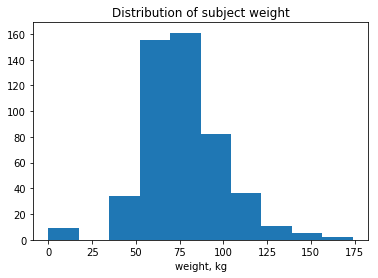

In [41]:
weight = np.nan_to_num(ccPerStudy["PatientWeight"].values)
plt.hist(weight)
plt.xlabel("weight, kg")
plt.title("Distribution of subject weight")
plt.show()

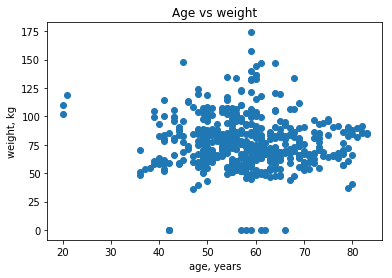

In [42]:
# Age is encoded as 048Y, so we need to strip off the suffix
age = [int(a[:-1]) for a in ccPerStudy["PatientAge"].values]
plt.scatter(age, weight)
plt.xlabel("age, years")
plt.ylabel("weight, kg")
plt.title("Age vs weight")
plt.show()

## Image segmentations

`CompositeContext` table contains information for all DICOM objects, including modality, so we can first confirm how many subjects have segmentations.

In [43]:
# select only those studies that have Segmentations
segSeries = CompositeContext_df[CompositeContext_df["Modality"]=="SEG"].drop_duplicates(subset="StudyInstanceUID")
print("This many studies include segmentations: %i " % (segSeries.shape[0]))
print("This many patients: %i" % segSeries["PatientID"].unique().shape)

This many studies include segmentations: 60 
This many patients: 59


Segmentations are organized as follows: (a fragment from [the overall schema](https://app.quickdatabasediagrams.com/#/schema/_71V1H1AXEqqKWDnvx4VXw))

![](https://www.dropbox.com/s/lrcbl895cv64giu/seg_relationships.png?raw=1)

There is a single entry corresponding to each segmentation series in the `SEG` table.

In [44]:
SEG_df = pd.read_csv(tablesPath+'/SEG.tsv', sep='\t', low_memory=False)
SEG_df.head()

,ClinicalTrialSeriesID,ClinicalTrialTimePointID,Columns,ContentCreatorName,NumberOfFrames,Rows,SOPInstanceUID,SegmentationType
0,1,1,512,Automated Aortic Arch Reference Region Segment...,12,512,1.2.276.0.7230010.3.1.4.8323329.18234.14400013...,BINARY
1,1,1,128,Automated Cerebellum Reference Region Segmenta...,14,128,1.2.276.0.7230010.3.1.4.8323329.18264.14400013...,BINARY
2,1,1,128,Automated Liver Reference Region Segmentation,17,128,1.2.276.0.7230010.3.1.4.8323329.18294.14400013...,BINARY
3,1,1,128,User1,13,128,1.2.276.0.7230010.3.1.4.8323329.18355.14400013...,BINARY
4,2,1,128,User1,13,128,1.2.276.0.7230010.3.1.4.8323329.18414.14400013...,BINARY


In [45]:
SEG_df.columns

Index(['ClinicalTrialSeriesID', 'ClinicalTrialTimePointID', 'Columns',
       'ContentCreatorName', 'NumberOfFrames', 'Rows', 'SOPInstanceUID',
       'SegmentationType'],
      dtype='object')

We can merge the `CompositeContext` and `SEG` tables.

In [46]:
SEGSegments_df = pd.read_csv(tablesPath+'/SEG_Segments.tsv', sep='\t', low_memory=False)
SEGSegments_df.head()

,AnatomicRegionSequence_CodeMeaning,AnatomicRegionSequence_CodeValue,AnatomicRegionSequence_CodingSchemeDesignator,SOPInstanceUID,SegmentAlgorithmName,SegmentAlgorithmType,SegmentLabel,SegmentNumber,SegmentedPropertyCategoryCodeSequence_CodeMeaning,SegmentedPropertyCategoryCodeSequence_CodeValue,SegmentedPropertyCategoryCodeSequence_CodingSchemeDesignator,SegmentedPropertyTypeCodeSequence_CodeMeaning,SegmentedPropertyTypeCodeSequence_CodeValue,SegmentedPropertyTypeCodeSequence_CodingSchemeDesignator
0,Aortic arch,T-42300,SRT,1.2.276.0.7230010.3.1.4.8323329.18234.14400013...,Iowa QIN Aortic Arch Segmentation,AUTOMATIC,Reference Region,1,Spatial and Relational Concept,R-42018,SRT,Reference Region,C94970,NCIt
1,Cerebellum,T-A6000,SRT,1.2.276.0.7230010.3.1.4.8323329.18264.14400013...,Iowa QIN Cerebellum Segmentation,AUTOMATIC,Reference Region,1,Spatial and Relational Concept,R-42018,SRT,Reference Region,C94970,NCIt
2,Liver,T-62000,SRT,1.2.276.0.7230010.3.1.4.8323329.18294.14400013...,Iowa QIN Liver Segmentation,AUTOMATIC,Reference Region,1,Spatial and Relational Concept,R-42018,SRT,Reference Region,C94970,NCIt
3,pharyngeal tonsil (adenoid),T-C5300,SRT,1.2.276.0.7230010.3.1.4.8323329.18355.14400013...,NaN,MANUAL,"Neoplasm, Primary",1,Morphologically Altered Structure,M-01000,SRT,"Neoplasm, Primary",M-80003,SRT
4,pharyngeal tonsil (adenoid),T-C5300,SRT,1.2.276.0.7230010.3.1.4.8323329.18414.14400013...,NaN,MANUAL,"Neoplasm, Primary",1,Morphologically Altered Structure,M-01000,SRT,"Neoplasm, Primary",M-80003,SRT


In [47]:
SEGSegments_df.columns

Index(['AnatomicRegionSequence_CodeMeaning',
       'AnatomicRegionSequence_CodeValue',
       'AnatomicRegionSequence_CodingSchemeDesignator', 'SOPInstanceUID',
       'SegmentAlgorithmName', 'SegmentAlgorithmType', 'SegmentLabel',
       'SegmentNumber', 'SegmentedPropertyCategoryCodeSequence_CodeMeaning',
       'SegmentedPropertyCategoryCodeSequence_CodeValue',
       'SegmentedPropertyCategoryCodeSequence_CodingSchemeDesignator',
       'SegmentedPropertyTypeCodeSequence_CodeMeaning',
       'SegmentedPropertyTypeCodeSequence_CodeValue',
       'SegmentedPropertyTypeCodeSequence_CodingSchemeDesignator'],
      dtype='object')

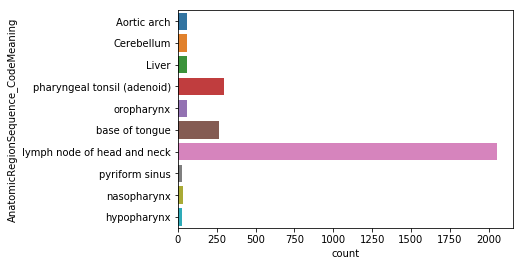

In [48]:
%matplotlib inline
import seaborn as sns
import matplotlib
sns.countplot(y="AnatomicRegionSequence_CodeMeaning",data=SEGSegments_df)

In [49]:
SEG_merged = pd.merge(CompositeContext_df,SEGDF,on="SOPInstanceUID")
SEG_merged = pd.merge(SEG_merged, SEGSegments_df, on="SOPInstanceUID")

In [50]:
SEG_merged.columns

Index(['BodyPartExamined', 'ManufacturerModelName', 'Modality', 'PatientAge',
       'PatientID', 'PatientName', 'PatientSex', 'PatientWeight',
       'SOPClassUID', 'SOPInstanceUID', 'SeriesDate', 'SeriesDescription',
       'SeriesInstanceUID', 'SeriesTime', 'SoftwareVersions', 'StudyDate',
       'StudyDescription', 'StudyInstanceUID', 'StudyTime',
       'ClinicalTrialSeriesID', 'ClinicalTrialTimePointID', 'Columns',
       'ContentCreatorName', 'NumberOfFrames', 'Rows', 'SegmentationType',
       'AnatomicRegionSequence_CodeMeaning',
       'AnatomicRegionSequence_CodeValue',
       'AnatomicRegionSequence_CodingSchemeDesignator', 'SegmentAlgorithmName',
       'SegmentAlgorithmType', 'SegmentLabel', 'SegmentNumber',
       'SegmentedPropertyCategoryCodeSequence_CodeMeaning',
       'SegmentedPropertyCategoryCodeSequence_CodeValue',
       'SegmentedPropertyCategoryCodeSequence_CodingSchemeDesignator',
       'SegmentedPropertyTypeCodeSequence_CodeMeaning',
       'SegmentedProper

In [51]:
SEG_merged["SeriesDescription"].value_counts()

tumor segmentation - User3 SemiAuto trial 1    230
tumor segmentation - User3 Manual trial 1      230
tumor segmentation - User1 SemiAuto trial 1    230
tumor segmentation - User1 Manual trial 2      230
tumor segmentation - User1 Manual trial 1      230
tumor segmentation - User2 SemiAuto trial 1    230
tumor segmentation - User2 Manual trial 1      230
tumor segmentation - User3 SemiAuto trial 2    230
tumor segmentation - User1 SemiAuto trial 2    230
tumor segmentation - User3 Manual trial 2      230
tumor segmentation - User2 SemiAuto trial 2    230
tumor segmentation - User2 Manual trial 2      230
auto liver segmentation                         59
auto aorta segmentation                         57
auto cerebellum segmentation                    57
manual cerebellum segmentation                   3
manual aorta segmentation                        3
manual liver segmentation                        1
Name: SeriesDescription, dtype: int64

In [52]:
SEG_merged["SegmentAlgorithmType"].value_counts()

MANUAL           1387
SEMIAUTOMATIC    1380
AUTOMATIC         173
Name: SegmentAlgorithmType, dtype: int64

lymph node of head and neck    171
pharyngeal tonsil (adenoid)     25
base of tongue                  22
oropharynx                       5
nasopharynx                      3
hypopharynx                      2
pyriform sinus                   2
Name: AnatomicRegionSequence_CodeMeaning, dtype: int64

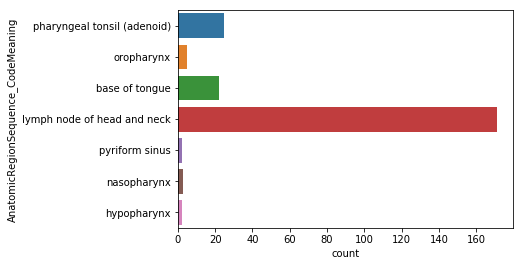

In [53]:
oneReaderOneSession = SEG_merged[SEG_merged["SeriesDescription"]=="tumor segmentation - User1 SemiAuto trial 1"]
sns.countplot(y="AnatomicRegionSequence_CodeMeaning",data=oneReaderOneSession)
oneReaderOneSession["AnatomicRegionSequence_CodeMeaning"].value_counts()

Let's figure out how many structures were segmented in each of the studies. 

`SEG_merged` table has one row per segment, and each row contains `PatientID`, because of the way we constructed it. So we can just count the number of times each of the `PatientID`s is encountered.


In [54]:
SEG_merged["PatientID"].value_counts()

QIN-HEADNECK-01-0067    147
QIN-HEADNECK-01-0139    135
QIN-HEADNECK-01-0366    123
QIN-HEADNECK-01-0239    111
QIN-HEADNECK-01-0057    111
QIN-HEADNECK-01-0047    102
QIN-HEADNECK-01-0190     99
QIN-HEADNECK-01-0135     87
QIN-HEADNECK-01-0180     87
QIN-HEADNECK-01-0100     75
QIN-HEADNECK-01-0112     75
QIN-HEADNECK-01-0089     75
QIN-HEADNECK-01-0201     75
QIN-HEADNECK-01-0228     63
QIN-HEADNECK-01-0165     63
QIN-HEADNECK-01-0186     51
QIN-HEADNECK-01-0203     51
QIN-HEADNECK-01-0129     51
QIN-HEADNECK-01-0071     51
QIN-HEADNECK-01-0118     51
QIN-HEADNECK-01-0220     51
QIN-HEADNECK-01-0140     51
QIN-HEADNECK-01-0064     51
QIN-HEADNECK-01-0086     51
QIN-HEADNECK-01-0244     51
QIN-HEADNECK-01-0079     51
QIN-HEADNECK-01-0026     51
QIN-HEADNECK-01-0074     51
QIN-HEADNECK-01-0028     39
QIN-HEADNECK-01-0041     39
QIN-HEADNECK-01-0120     39
QIN-HEADNECK-01-0199     39
QIN-HEADNECK-01-0275     39
QIN-HEADNECK-01-0224     39
QIN-HEADNECK-01-0184     39
QIN-HEADNECK-01-0062

In [55]:
SEG_merged[SEG_merged["PatientID"] == "QIN-HEADNECK-01-0067"]["SeriesDescription"].value_counts()

tumor segmentation - User3 Manual trial 1      12
tumor segmentation - User3 SemiAuto trial 1    12
tumor segmentation - User2 SemiAuto trial 1    12
tumor segmentation - User2 SemiAuto trial 2    12
tumor segmentation - User3 Manual trial 2      12
tumor segmentation - User1 SemiAuto trial 2    12
tumor segmentation - User3 SemiAuto trial 2    12
tumor segmentation - User2 Manual trial 2      12
tumor segmentation - User2 Manual trial 1      12
tumor segmentation - User1 Manual trial 2      12
tumor segmentation - User1 Manual trial 1      12
tumor segmentation - User1 SemiAuto trial 1    12
auto liver segmentation                         1
auto aorta segmentation                         1
auto cerebellum segmentation                    1
Name: SeriesDescription, dtype: int64

# Segmentation-based measurements

In [56]:
SR_df = pd.read_csv(tablesPath+'/SR.tsv', sep='\t', low_memory=False)
SR1500_MeasurementGroups_df = pd.read_csv(tablesPath+'/SR1500_MeasurementGroups.tsv', sep='\t', low_memory=False)
SR1500_Measurements_df = pd.read_csv(tablesPath+'/SR1500_Measurements.tsv', sep='\t', low_memory=False)

In [57]:
SR_df.columns

Index(['CompletionFlag', 'SOPInstanceUID', 'TemplateIdentifier',
       'VerificationFlag'],
      dtype='object')

In [58]:
SR1500_MeasurementGroups_df.columns

Index(['DeviceObserverName', 'FindingSite_CodeMeaning',
       'FindingSite_CodeValue', 'FindingSite_CodingSchemeDesignator',
       'Finding_CodeMeaning', 'Finding_CodeValue',
       'Finding_CodingSchemeDesignator', 'ObserverType', 'PersonObserverName',
       'SOPInstanceUID', 'TrackingIdentifier', 'TrackingUniqueIdentifier',
       'activitySession', 'measurementMethod_CodeMeaning',
       'measurementMethod_CodeValue',
       'measurementMethod_CodingSchemeDesignator', 'timePoint'],
      dtype='object')

In [59]:
SR1500_Measurements_df.columns

Index(['SOPInstanceUID', 'TrackingUniqueIdentifier',
       'derivationModifier_CodeMeaning', 'derivationModifier_CodeValue',
       'derivationModifier_CodingSchemeDesignator', 'quantity_CodeMeaning',
       'quantity_CodeValue', 'quantity_CodingSchemeDesignator',
       'units_CodeMeaning', 'units_CodeValue', 'units_CodingSchemeDesignator',
       'value'],
      dtype='object')

Each finding is uniquely identified, so we can track measurements for the same finding done by different tools/readers, or over longitudinally over the period of time.

In [60]:
SR1500_MeasurementGroups_df["TrackingUniqueIdentifier"].value_counts()

2.25.115988184857360261395218474256090216364    12
2.25.130838263999915763240244948783750657964    12
2.25.26204673713330650616301797533567367084     12
2.25.327754131831492883749226707242039850924    12
2.25.148854382121548657707777160917106505644    12
2.25.324064553154521232383902831212524156844    12
2.25.320370907695967723830130278572037715884    12
2.25.86405936300547861320302365113977878444     12
2.25.37019651447091917750681815574462281644     12
2.25.66856991711033119855991234108910942124     12
2.25.64540722311818720812778811496939337644     12
2.25.41561661770187041977042149674433066924     12
2.25.113234422298431845535674757563000240044    12
2.25.103079984808902877894036258209407121324    12
2.25.105182251810631622677618135192565659564    12
2.25.31052150593844396424184168140377110444     12
2.25.99750201817230754594452439579794290604     12
2.25.127380548125105356744175330995772274604    12
2.25.111209773542955075238346523717106874284    12
2.25.89289736693769369466729150

Note that `SOPInstanceUID` is attached to every item to link to the DICOM instance where it comes from. `TrackingUniqueIdentifier` is unique for every structure being segmented, and comes up 12 times for each finding that is not a reference region: had 3 users, with each user segmenting the same structure using manual or semi-automatic approaches, on 2 occasions - 3x2x2 = 12.

Since measurements for the segmentations produced using each combination of user/segmentation method/segmentation session is stored into a separate series, we can uniquely match attributes of the MeasurementGroup with the individual measurements by merging on the combination of `SOPInstanceUID` and `TrackingUniqueIdentifier` keys.

In [61]:
SR_merged = pd.merge(SR1500_Measurements_df,SR1500_MeasurementGroups_df,on=["SOPInstanceUID","TrackingUniqueIdentifier"])
SR_merged.shape

(60531, 27)

In [62]:
SR_merged.columns

Index(['SOPInstanceUID', 'TrackingUniqueIdentifier',
       'derivationModifier_CodeMeaning', 'derivationModifier_CodeValue',
       'derivationModifier_CodingSchemeDesignator', 'quantity_CodeMeaning',
       'quantity_CodeValue', 'quantity_CodingSchemeDesignator',
       'units_CodeMeaning', 'units_CodeValue', 'units_CodingSchemeDesignator',
       'value', 'DeviceObserverName', 'FindingSite_CodeMeaning',
       'FindingSite_CodeValue', 'FindingSite_CodingSchemeDesignator',
       'Finding_CodeMeaning', 'Finding_CodeValue',
       'Finding_CodingSchemeDesignator', 'ObserverType', 'PersonObserverName',
       'TrackingIdentifier', 'activitySession',
       'measurementMethod_CodeMeaning', 'measurementMethod_CodeValue',
       'measurementMethod_CodingSchemeDesignator', 'timePoint'],
      dtype='object')

In [63]:
SR_merged["PersonObserverName"].value_counts()

User3    19712
User2    19694
User1    19685
User4       48
User5        8
Name: PersonObserverName, dtype: int64

Didn't expect to see `User4` and `User5` ... what are they?

In [64]:
SR_merged[SR_merged["PersonObserverName"].isin(["User4","User5"])]["FindingSite_CodeMeaning"]

2152     Aortic arch
2153     Aortic arch
2154     Aortic arch
2155     Aortic arch
2156     Aortic arch
2157     Aortic arch
2158     Aortic arch
2159     Aortic arch
6963           Liver
6964           Liver
6965           Liver
6966           Liver
6967           Liver
6968           Liver
6969           Liver
6970           Liver
35589    Aortic arch
35590    Aortic arch
35591    Aortic arch
35592    Aortic arch
35593    Aortic arch
35594    Aortic arch
35595    Aortic arch
35596    Aortic arch
35597     Cerebellum
35598     Cerebellum
35599     Cerebellum
35600     Cerebellum
35601     Cerebellum
35602     Cerebellum
35603     Cerebellum
35604     Cerebellum
36665     Cerebellum
36666     Cerebellum
36667     Cerebellum
36668     Cerebellum
36669     Cerebellum
36670     Cerebellum
36671     Cerebellum
36672     Cerebellum
57158    Aortic arch
57159    Aortic arch
57160    Aortic arch
57161    Aortic arch
57162    Aortic arch
57163    Aortic arch
57164    Aortic arch
57165    Aort

Now let's add all of the composite context information so that we know what patient each measurement belongs to.

In [65]:
SR_merged=pd.merge(SR_merged, CompositeContext_df, on="SOPInstanceUID")
SR_merged.shape

(60531, 45)

In [66]:
SR_merged.columns

Index(['SOPInstanceUID', 'TrackingUniqueIdentifier',
       'derivationModifier_CodeMeaning', 'derivationModifier_CodeValue',
       'derivationModifier_CodingSchemeDesignator', 'quantity_CodeMeaning',
       'quantity_CodeValue', 'quantity_CodingSchemeDesignator',
       'units_CodeMeaning', 'units_CodeValue', 'units_CodingSchemeDesignator',
       'value', 'DeviceObserverName', 'FindingSite_CodeMeaning',
       'FindingSite_CodeValue', 'FindingSite_CodingSchemeDesignator',
       'Finding_CodeMeaning', 'Finding_CodeValue',
       'Finding_CodingSchemeDesignator', 'ObserverType', 'PersonObserverName',
       'TrackingIdentifier', 'activitySession',
       'measurementMethod_CodeMeaning', 'measurementMethod_CodeValue',
       'measurementMethod_CodingSchemeDesignator', 'timePoint',
       'BodyPartExamined', 'ManufacturerModelName', 'Modality', 'PatientAge',
       'PatientID', 'PatientName', 'PatientSex', 'PatientWeight',
       'SOPClassUID', 'SeriesDate', 'SeriesDescription', 'Serie

## Plot measurements

Each finding was expected to be segmented by each of the 3 users, using automated or manual approach, two times each (12 segmentations total). Each finding is assigned a unique identifier, so we can look at the consistency of the segmentation across readers, across segmentation approaches, and across segmentation sessions.

But first, let's check and confirm that we have all 12 sets of measurements for each of the unique tracking identifier. Let's only consider primary and secondary neoplasms.



In [67]:
SR_merged["Finding_CodeMeaning"].unique()

array(['Reference Region', 'Neoplasm, Primary', 'Neoplasm, Secondary'], dtype=object)

In [68]:
SR_merged.groupby(['quantity_CodeMeaning','derivationModifier_CodeMeaning']).size().reset_index().rename(columns={0:'count'})

,quantity_CodeMeaning,derivationModifier_CodeMeaning,count
0,SUVbw,25th Percentile Value,2940
1,SUVbw,75th Percentile Value,2940
2,SUVbw,Maximum,2940
3,SUVbw,Mean,2940
4,SUVbw,Median,2940
5,SUVbw,Minimum,2940
6,SUVbw,Peak Value Within ROI,1131
7,SUVbw,RMS,2760
8,SUVbw,Standard Deviation,2940
9,SUVbw,Upper Adjacent Value,2760


In [69]:
SR_merged.groupby(['quantity_CodeMeaning']).size().reset_index().rename(columns={0:'count'})

,quantity_CodeMeaning,count
0,Glycolysis Within First Quarter of Intensity R...,2760
1,Glycolysis Within Fourth Quarter of Intensity ...,2760
2,Glycolysis Within Second Quarter of Intensity ...,2760
3,Glycolysis Within Third Quarter of Intensity R...,2760
4,Percent Within First Quarter of Intensity Range,2760
5,Percent Within Fourth Quarter of Intensity Range,2760
6,Percent Within Second Quarter of Intensity Range,2760
7,Percent Within Third Quarter of Intensity Range,2760
8,SUVbw,27231
9,Standardized Added Metabolic Activity,2760


In [70]:
SR_merged["quantity_CodeMeaning"].unique()

array(['SUVbw', 'Volume', 'Total Lesion Glycolysis',
       'Glycolysis Within First Quarter of Intensity Range',
       'Glycolysis Within Second Quarter of Intensity Range',
       'Glycolysis Within Third Quarter of Intensity Range',
       'Glycolysis Within Fourth Quarter of Intensity Range',
       'Percent Within First Quarter of Intensity Range',
       'Percent Within Second Quarter of Intensity Range',
       'Percent Within Third Quarter of Intensity Range',
       'Percent Within Fourth Quarter of Intensity Range',
       'Standardized Added Metabolic Activity',
       'Standardized Added Metabolic Activity Background'], dtype=object)

In [71]:
SR_merged["derivationModifier_CodeMeaning"].unique()

array(['Mean', 'Minimum', 'Maximum', nan, 'Standard Deviation',
       '25th Percentile Value', 'Median', '75th Percentile Value',
       'Peak Value Within ROI', 'Upper Adjacent Value', 'RMS'], dtype=object)

Observe how for some measurements we have 12 items for a given finding type (and there is always Primary tumor present):

Since we have volume of the primary tumor available for every subject, let's see how much it varies across users, tools and segmentation sessions.

In [72]:
SR_merged[SR_merged["Finding_CodeMeaning"]=="Neoplasm, Primary"][SR_merged["quantity_CodeMeaning"]=="Volume"]["PatientID"].shape[0]/12

/Users/fedorov/.pyenv/versions/3.5.3/lib/python3.5/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


59.0

... and for others less than that, since some of the measurements cannot always be computed!

In [73]:
SR_merged[SR_merged["Finding_CodeMeaning"]=="Neoplasm, Primary"][SR_merged["derivationModifier_CodeMeaning"]=="Peak Value Within ROI"]["PatientID"].shape[0]/12

/Users/fedorov/.pyenv/versions/3.5.3/lib/python3.5/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


46.916666666666664

Since we have volume of the primary tumor available for every subject, let's see how much it varies across users, tools and segmentation sessions. Lets factor out the segmentation tool type. Note that the segmentation tool type is encoded directly in the SEG objects, but it is more convenient to take it from the series description of the SR objects storing the measurements.

In [74]:
SR_merged["segmentationToolType"] = \
 SR_merged["SeriesDescription"].apply(lambda toolType: toolType.split(" ")[-3] if toolType.split(" ")[-3] in ["Manual","SemiAuto"] else "Auto")
SR_merged["segmentationToolType"]

0            Auto
1            Auto
2            Auto
3            Auto
4            Auto
5            Auto
6            Auto
7            Auto
8            Auto
9            Auto
10           Auto
11           Auto
12           Auto
13           Auto
14           Auto
15           Auto
16           Auto
17           Auto
18           Auto
19           Auto
20           Auto
21           Auto
22           Auto
23           Auto
24         Manual
25         Manual
26         Manual
27         Manual
28         Manual
29         Manual
           ...   
60501    SemiAuto
60502    SemiAuto
60503    SemiAuto
60504    SemiAuto
60505    SemiAuto
60506    SemiAuto
60507    SemiAuto
60508    SemiAuto
60509    SemiAuto
60510    SemiAuto
60511    SemiAuto
60512    SemiAuto
60513    SemiAuto
60514    SemiAuto
60515    SemiAuto
60516    SemiAuto
60517    SemiAuto
60518    SemiAuto
60519    SemiAuto
60520    SemiAuto
60521    SemiAuto
60522    SemiAuto
60523    SemiAuto
60524    SemiAuto
60525    S

First load the references

In [95]:
References_df=pd.read_csv(tablesPath+'/References.tsv', sep='\t', low_memory=False)
References_df.columns

Index(['ReferencedSOPClassUID', 'ReferencedSOPInstanceUID', 'SOPInstanceUID',
       'SeriesInstanceUID'],
      dtype='object')

In [125]:
References_df.shape

(316629, 4)

In [127]:
References_df[References_df["SOPInstanceUID"]=="1.2.276.0.7230010.3.1.4.8323329.18258.1440001306.617244"]["SeriesInstanceUID"].unique()

array(['1.3.6.1.4.1.14519.5.2.1.2744.7002.261560220703676715130542397405',
       '1.2.276.0.7230010.3.1.4.8323329.18215.1440001297.928456',
       '1.2.276.0.7230010.3.1.3.8323329.18234.1440001306.224430'], dtype=object)

In [138]:
# WIP: do not run this!
series_df=CompositeContext_df.drop_duplicates(subset="SeriesInstanceUID")

# All references to SEG (only Measurements point to SEG in our case, 
#  and each SR should point to exactly one SEG!)
segReferences = References_df[References_df["ReferencedSOPClassUID"]=='1.2.840.10008.5.1.4.1.1.66.4']
segReferences = segReferences[["SOPInstanceUID","SeriesInstanceUID"]].rename(columns={"SeriesInstanceUID":"ReferencedSeriesInstanceUID"})
segReferences.shape

(900, 2)

In [148]:
References_df.shape
CompositeContext_df.shape

(353252, 19)

In [149]:
from bokeh.models import ColumnDataSource, OpenURL, TapTool
from bokeh.plotting import figure, output_file, show
from bokeh.io import output_notebook
from bokeh.colors import RGB

from bokeh.models import HoverTool, PanTool, WheelZoomTool, BoxZoomTool, ResetTool, TapTool

output_notebook()

volume = []
user = []
method = []
sesssion = []
subject = []

SR_merged = pd.merge(SR_merged, segReferences)

subset = SR_merged[SR_merged["PersonObserverName"]=="User1"]
subset = subset[subset["Finding_CodeMeaning"]=="Neoplasm, Primary"]
subset = subset[subset["quantity_CodeMeaning"]=="Volume"]
#subset = subset[subset["activitySession"]==1]
#subset = subset[subset["segmentationToolType"]=="SemiAuto"]

#subset.sort_values("value", inplace=True)

volumes = subset["value"].values
observers = subset["PersonObserverName"].values
subjects = subset["PatientID"].values

subset["segmentationToolType"].unique()

colormap = {'1-Manual': 'red', '2-Manual': 'red', '1-SemiAuto': 'blue', '2-SemiAuto': 'blue'}
colors = [colormap[x] for x in (subset["activitySession"].map(str)+'-'+subset['segmentationToolType']).tolist()]

source = ColumnDataSource(data=dict(
    x=volumes,
    y=subjects,
    color=colors,
    seriesUID=subset["ReferencedSeriesInstanceUID"]
    ))

hover = HoverTool(tooltips=[
    ("(Volume, Subject)", "($x, $y)")
])

wZoom = WheelZoomTool()
bZoom = BoxZoomTool()
reset = ResetTool()
tap = TapTool()
pan = PanTool()

p = figure(x_range=[np.min(volumes),np.max(volumes)],y_range=subjects.tolist(), tools = [hover, wZoom, bZoom, reset, tap, pan],title="Volume segmentation consistency by User1; manual (red circles) and SemiAutomatic (blue circles)")
p.yaxis.axis_label = "PatientID"
p.xaxis.axis_label = subset["quantity_CodeMeaning"].values[0]+', '+subset['units_CodeMeaning'].values[0]

p.circle('x','y',color='color',source=source)

url = "http://pieper.github.com/dcmjs/examples/qiicr/?seriesUID=@seriesUID"
taptool = p.select(type=TapTool)
taptool.callback = OpenURL(url=url)

show(p)

Loading BokehJS ...